In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import savgol_filter
import json
import glob

datadir = 'LOSC_Event_tutorial/'

In [2]:
# Copied from the class example

def read_template(filename):
    dataFile = h5py.File(filename, 'r')
    template = dataFile['template']
    th = template[0]
    tl = template[1]
    return th, tl

def read_file(filename):
    dataFile = h5py.File(filename, 'r')
    dqInfo = dataFile['quality']['simple']
    qmask = dqInfo['DQmask'][...]

    meta = dataFile['meta']
    gpsStart = meta['GPSstart'][()]
    utc = meta['UTCstart'][()]
    duration = meta['Duration'][()]
    strain = dataFile['strain']['Strain'][()]
    dt = (1.0 * duration) / len(strain)

    dataFile.close()
    return strain, dt, utc

In [3]:
# Loading files so the data from the same events have the same index

with open(datadir + 'BBH_events_v3.json') as json_file:
    bbhev = json.load(json_file)

ths = []
tls = []
hstrain = []
hdt = []
hutc = []
lstrain = []
ldt = []
lutc = []

events = list(bbhev.keys())

for event in events:
    th, tl = read_template(datadir + bbhev[event]['fn_template'])
    ths.append(th)
    tls.append(tl)

    s, t, u = read_file(datadir + bbhev[event]['fn_H1'])
    hstrain.append(s)
    hdt.append(t)
    hutc.append(u)

    s, t, u = read_file(datadir + bbhev[event]['fn_L1'])
    lstrain.append(s)
    ldt.append(t)
    lutc.append(u)

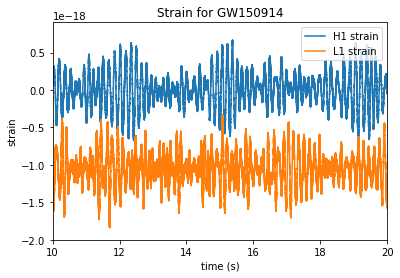

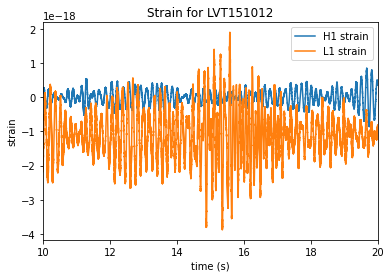

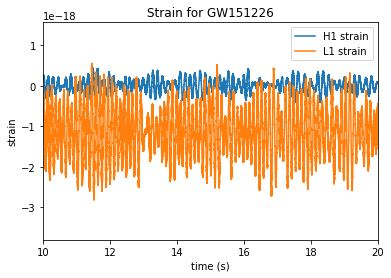

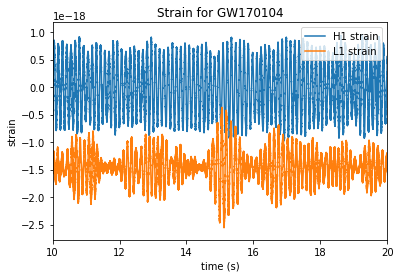

In [4]:
# Vizualizing signal

for i in range(len(events)):
    plt.figure()
    plt.plot(hdt[i] * np.arange(len(hstrain[i])), hstrain[i], label='H1 strain')
    plt.plot(ldt[i] * np.arange(len(lstrain[i])), lstrain[i], label='L1 strain')
    plt.xlabel('time (s)')
    plt.legend(loc='upper right')
    plt.title(f"Strain for {events[i]}")
    plt.xlim((10, 20))
    plt.ylabel('strain')
    plt.savefig(f"strain_{events[i]}.png")

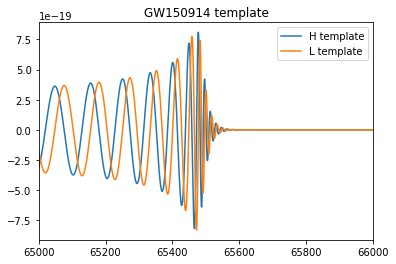

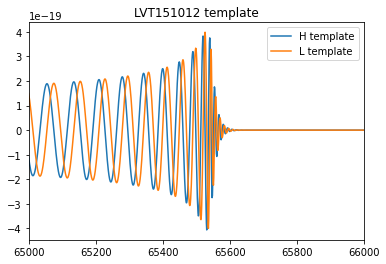

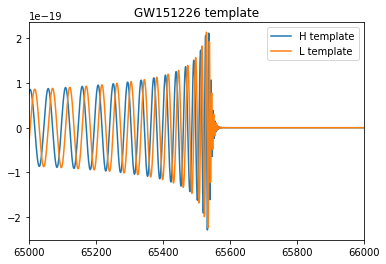

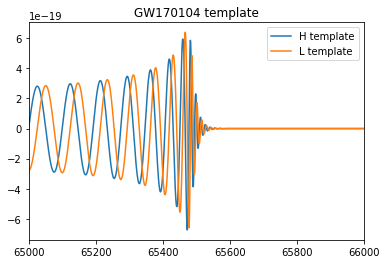

In [5]:
# Vizualizing templates
for i in range(len(events)):
    plt.figure()
    plt.plot(ths[i], label='H template')
    plt.plot(tls[i], label='L template')
    plt.legend(loc='upper right')
    plt.title(f"{events[i]} template")
    plt.xlim((6.5e4, 6.6e4))
    plt.show()

I used window function that was suggested in class (`make_flat_window`). It looks like simplified version of [Tukey window](https://en.wikipedia.org/wiki/Window_function#Tukey_window), which is good for this case, because we are interested in obtaining wide noise range in the final result.

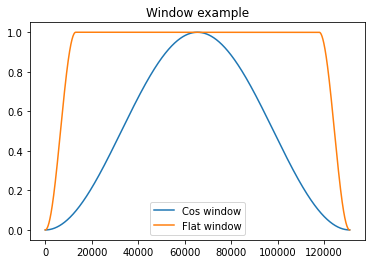

In [6]:
def make_window(n):
    x = np.linspace(-np.pi, np.pi, n)
    return 0.5 + 0.5 * np.cos(x)

def make_flat_window(n, m):
    tmp = make_window(m)
    win = np.ones(n)
    mm = m//2
    win[:mm] = tmp[:mm]
    win[-mm:] = tmp[-mm:]
    return win

n = len(hstrain[0])
win = make_window(n)
win_flat = make_flat_window(n,n//5)
plt.plot(win, label='Cos window')
plt.plot(win_flat, label='Flat window')
plt.legend()
plt.title("Window example")
plt.savefig('window_example.png')

To make a noise model we treat all data as a noise and then smoothing it, so the actual signal we are interested in will remain a 'deviation' from the noise model. This 'deviation' is hidden somewhere in the small numerous peaks and smoothing the model we make sure that actual signal will not be removed during 'whitening' of data.

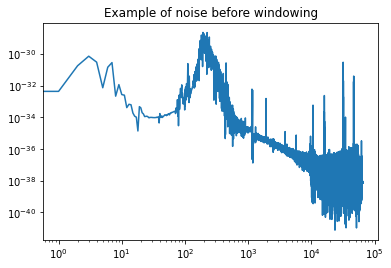

In [7]:
# Threat all data as a noise
sft = np.fft.rfft(hstrain[0])
Nft = np.abs(sft)**2
plt.loglog(Nft)
plt.title("Example of noise before windowing")
plt.savefig("noise_before_windowing.png")

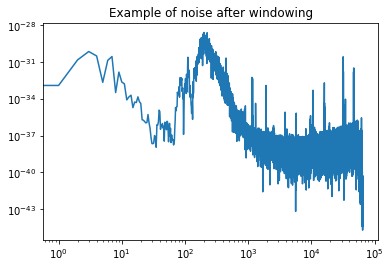

In [8]:
sft = np.fft.rfft(win_flat * hstrain[0])
Nft = np.abs(sft)**2
plt.loglog(Nft)
plt.title("Example of noise after windowing")
plt.savefig("noise_after_windowing.png")

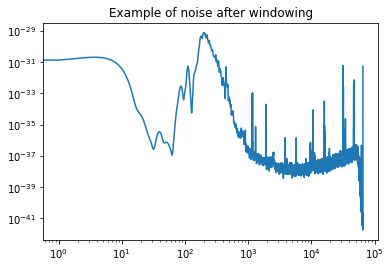

In [9]:
# I tried using more sophisticated methods of smoothing including smoothing by convolving data with box function,
#  but in the end the result is almost the same in every case so I decided to use the simpliest method suggested in class

# def smooth_convolve(y, box_pts):
#     box = np.ones(box_pts) / box_pts
#     y_smooth = np.convolve(y, box, mode='same')
#     return y_smooth

def smooth(y):
    for i in range(10):
        y = (y + np.roll(y, 1) + np.roll(y, -1)) / 3
    return y

Nft = smooth(Nft)
plt.loglog(Nft)
plt.title("Example of noise after windowing")
plt.savefig("noise_after_smoothing.png")

In [10]:
# Calculating noise model for each observation: windowing and smoothing
hnm = [smooth(np.abs(np.fft.rfft(make_flat_window(len(s), len(s)//5) * s))**2) for s in hstrain]
lnm = [smooth(np.abs(np.fft.rfft(make_flat_window(len(s), len(s)//5) * s))**2) for s in lstrain]

# 'Whitening' data
hsft_white = [np.fft.rfft(make_flat_window(len(s), len(s)//5) * hstrain[i]) / np.sqrt(hnm[i]) for i in range(len(hstrain))]
lsft_white = [np.fft.rfft(make_flat_window(len(s), len(s)//5) * lstrain[i]) / np.sqrt(lnm[i]) for i in range(len(lstrain))]

# Windowing and 'whitening' templates
thsft_white = [np.fft.rfft(ths[i] * make_flat_window(len(ths[i]), len(ths[i])//5)) / np.sqrt(hnm[i]) for i in range(len(events))]
tlsft_white = [np.fft.rfft(tls[i] * make_flat_window(len(tls[i]), len(tls[i])//5)) / np.sqrt(lnm[i]) for i in range(len(events))]

# Back to real space
ths_white = [np.fft.irfft(tft) for tft in thsft_white]
tls_white = [np.fft.irfft(tft) for tft in tlsft_white]

# Matched filters!
hxcorr = [np.fft.irfft(hsft_white[i] * np.conj(thsft_white[i])) for i in range(len(events))]
lxcorr = [np.fft.irfft(lsft_white[i] * np.conj(tlsft_white[i])) for i in range(len(events))]

# Calculating Signal-to-Noise ratio
hsnr = [np.max(np.abs(corr)) / np.std(corr[:-30000]) for corr in hxcorr]
lsnr = [np.max(np.abs(corr)) / np.std(corr[:-30000]) for corr in lxcorr]

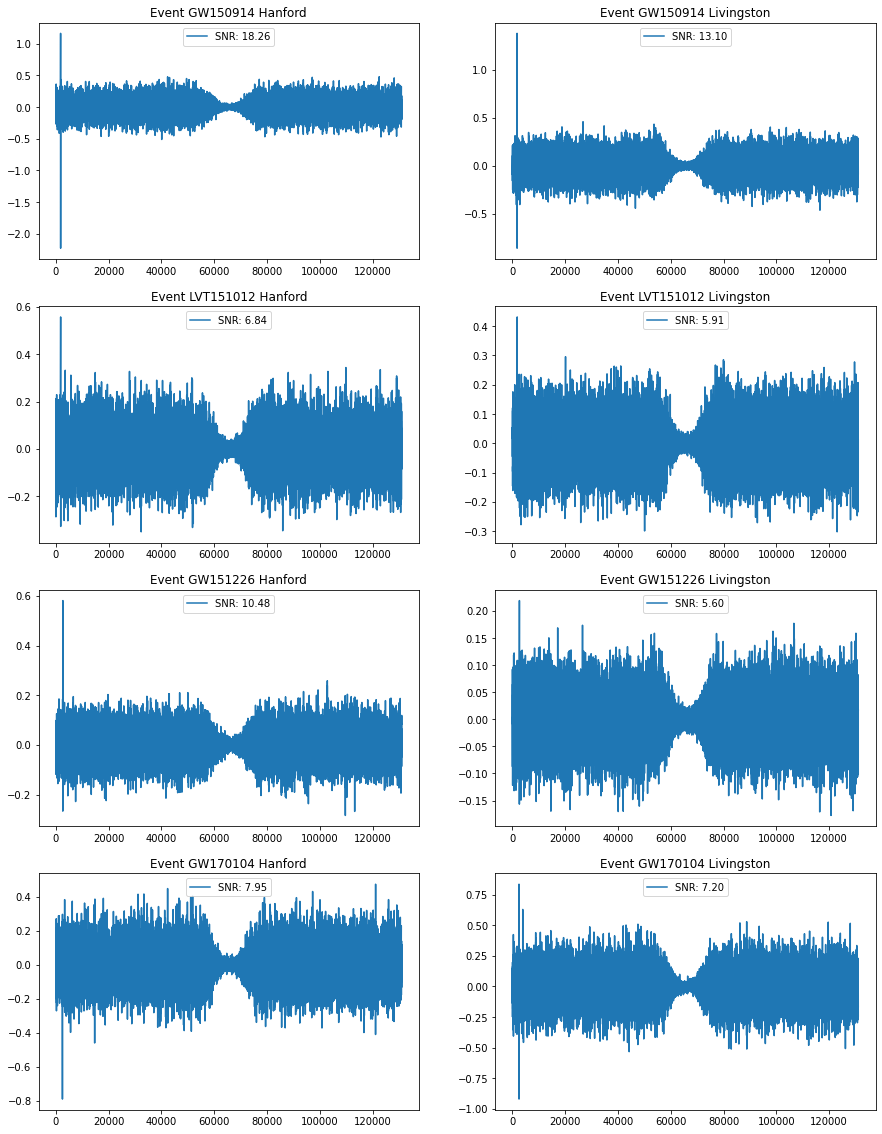

In [11]:
# Plotting results
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

for i in range(len(events)):
    axs[i, 0].plot(hxcorr[i], label=f'SNR: {hsnr[i]:.2f}')
    axs[i, 0].title.set_text(f'Event {events[i]} Hanford')
    axs[i, 0].legend(loc='upper center')

for i in range(len(events)):
    axs[i, 1].plot(lxcorr[i], label=f'SNR: {lsnr[i]:.2f}')
    axs[i, 1].title.set_text(f'Event {events[i]} Livingston')
    axs[i, 1].legend(loc='upper center')
    
plt.savefig("matched_filters.png", dpi=500)

In [13]:
print("Combined SNR:")
for i in range(len(events)):
    print(f"{events[i]}:\t{np.sqrt(hsnr[i]**2 + lsnr[i]**2):.2f}")

Combined SNR:
GW150914:	22.47
LVT151012:	9.04
GW151226:	11.88
GW170104:	10.73


Comparison of measured and analytic SNR shows that thet are very close, but it is obvious that there is some bias because the analytic SNR is always lower than measured. It is caused, probably, by my method of calculation of analytic noise - I calculate it over whole model including the peak, which implies higher sigma and lower SNR.

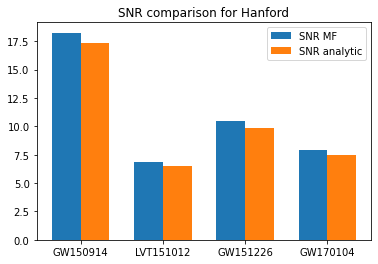

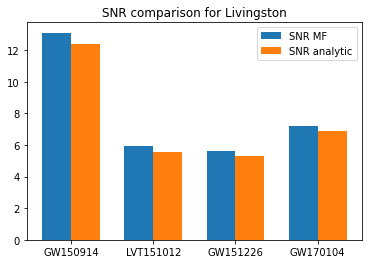

In [14]:
# Analityc SNR estimation

sig_ht = [np.std(tw) for tw in ths_white]
sig_lt = [np.std(tw) for tw in tls_white]

hsnr_teor = [np.max(np.abs(hxcorr[i])) / sig_ht[i] for i in range(len(events))]
lsnr_teor = [np.max(np.abs(lxcorr[i])) / sig_lt[i] for i in range(len(events))]

width = 0.35
ind = np.arange(len(events))

fig = plt.figure()
ax = fig.add_subplot(111)
bars1 = ax.bar(ind, hsnr, width, label='SNR MF')
rects2 = ax.bar(ind + width, hsnr_teor, width, label='SNR analytic')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(events)
plt.title("SNR comparison for Hanford")
plt.legend()
plt.savefig("cnr_comp_h.png")

fig = plt.figure()
ax = fig.add_subplot(111)
bars1 = ax.bar(ind, lsnr, width, label='SNR MF')
rects2 = ax.bar(ind + width, lsnr_teor, width, label='SNR analytic')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(events)
plt.title("SNR comparison for Livingston")
plt.legend()
plt.savefig("cnr_comp_l.png")

In [16]:
# Finding half-frequency

for i in range(len(events)):
    print(f"Event:\t{events[i]}")
    powh = np.abs(thsft_white[i])**2
    powl = np.abs(tlsft_white[i])**2
    normh = np.sum(powh)
    norml = np.sum(powl)
    cum_weighth = np.cumsum(powh) / normh
    cum_weightl = np.cumsum(powl) / norml
    fridnh = np.searchsorted(cum_weighth, 0.5)
    fridnl = np.searchsorted(cum_weightl, 0.5)
    freqsh = np.fft.rfftfreq(len(powh), d=hdt[i])
    freqsl = np.fft.rfftfreq(len(powl), d=ldt[i])
    print("\t|| Half cumsum index check:")
    print('\t||', cum_weighth[fridnh])
    print('\t||', cum_weightl[fridnl])
    print(f"H half-freq:\t{freqsh[fridnh]}")
    print(f"L half-freq:\t{freqsl[fridnl]}")
    print("=========================")

Event:	GW150914
	|| Half cumsum index check:
	|| 0.5000247285568483
	|| 0.5000080829513244
H half-freq:	202.99690251308422
L half-freq:	229.9339914857256
Event:	LVT151012
	|| Half cumsum index check:
	|| 0.5003575651317228
	|| 0.5000241093983616
H half-freq:	152.93516639455575
L half-freq:	193.37204937668798
Event:	GW151226
	|| Half cumsum index check:
	|| 0.5000928518939606
	|| 0.5002357457707245
H half-freq:	148.4352350580588
L half-freq:	215.12171750308985
Event:	GW170104
	|| Half cumsum index check:
	|| 0.5000059654955388
	|| 0.5000067909296776
H half-freq:	188.9971161328715
L half-freq:	150.24770740192562


^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

I will estimate localization error on the example of one event

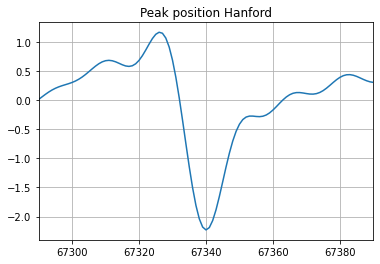

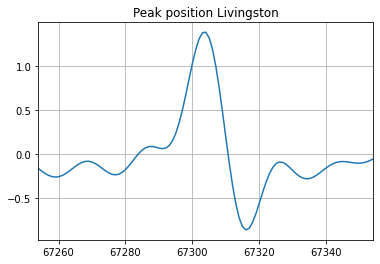

Time delay:	 0.0087890625
Error of t is approximately:	 0.00244140625


In [88]:
h_peak_pos = np.argmax(np.abs(np.fft.fftshift(hxcorr[0])))
plt.plot(np.fft.fftshift(hxcorr[0]))
plt.xlim((h_peak_pos-50, h_peak_pos+50))
plt.title("Peak position Hanford")
plt.grid()
plt.show()

l_peak_pos = np.argmax(np.abs(np.fft.fftshift(lxcorr[0])))
plt.plot(np.fft.fftshift(lxcorr[0]))
plt.xlim((l_peak_pos-50, l_peak_pos+50))
plt.title("Peak position Livingston")
plt.grid()
plt.show()

print("Time delay:\t", (h_peak_pos - l_peak_pos) * hdt[0])
print("Error of t is approximately:\t", 10 * hdt[0])

The FWHM of the peak was estimated just looking at the plot and equals approx. 10 time intervals or 0.00244140620 seconds. Time difference between two peaks is 0.0087890625. All further estimations are in the `part_f.pdf`.